In [26]:
install.packages('ggplot2')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [27]:
install.packages('dplyr')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [28]:
install.packages('minpack.lm')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [37]:
install.packages('TTR')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’




In [23]:
install.packages('keras3')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [29]:
library(dplyr)
library(ggplot2)
library(minpack.lm)
library(keras3)
library(TTR)

In [30]:
data = read.csv('merged_data.csv')

In [31]:
data <- data %>%
  mutate(Cumulative_Signed_Volume = cumsum(Signed.Volume)) %>%
  mutate(Mid_Price_Change = c(NA, diff(mid_price))) %>%
  na.omit()

In [32]:
T = nrow(data)
time = seq(1,T)
data['time_index'] = time

**Problem 1**

In [40]:
data$moving_avg = SMA(data$mid_price,50)
data$signal = (data$mid_price - data$moving_avg)/data$moving_avg
data = na.omit(data)

In [33]:
data1 = data[1:1000,]

In [83]:
ow_impact = function(Q, time, lambda, beta){
  J_t = vector()
  for(i in 1:length(time)){
    J = 0
    for(j in 1:i){
      J = J + exp(-beta * time[i-j+1])*Q[j]
    }
    J_t[i] = J
  }
  return (lambda*J_t)
}

In [84]:
ow_model = nlsLM(
  Mid_Price_Change ~ ow_impact(Signed.Volume, time_index, lambda, beta),
  data = data1,
  start = list(lambda = 0.001, beta = 1)
)

In [87]:
coef(ow_model)

lambda         beta 
2.310484e-05 1.069343e+01

In [85]:
data$ow_impact = predict(ow_model,data)

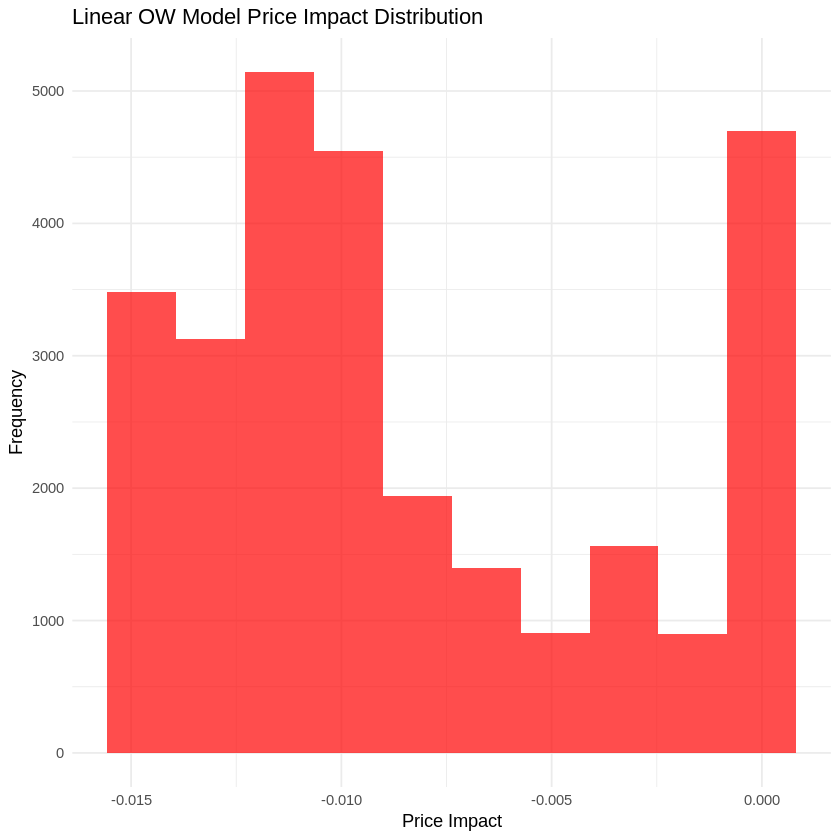

In [94]:
ggplot(data[data$ow_impact >= quantile(data$ow_impact, 0.25) - 1.5 * IQR(data$ow_impact) &
            data$ow_impact <= quantile(data$ow_impact, 0.75) + 1.5 * IQR(data$ow_impact), ]
  , aes(x = ow_impact)) +
  geom_histogram(bins = 10, fill = "red", alpha = 0.7) +
  labs(title = "Linear OW Model Price Impact Distribution",
       x = "Price Impact",
       y = "Frequency") +
  theme_minimal()

In [88]:
afs_impact = function(Q, time, lambda, beta, p){
  J_t = vector()
  for(i in 1:length(time)){
    J = 0
    for(j in 1:i){
      J = J + exp(-beta * time[i-j+1])*Q[j]
    }
    J_t[i] = J
  }
  return (lambda*sign(J_t)*abs(J_t)^p)
}

In [89]:
afs_model = nlsLM(
  Mid_Price_Change ~ afs_impact(Signed.Volume, time_index, lambda, beta, p),
  data = data1,
  start = list(lambda = 0.001, beta = 1, p = 1.5)
)

In [90]:
coef(afs_model)

lambda         beta            p 
 0.001478632  3.567987132 -0.275749222

In [91]:
data$afs_impact = predict(afs_model,data)

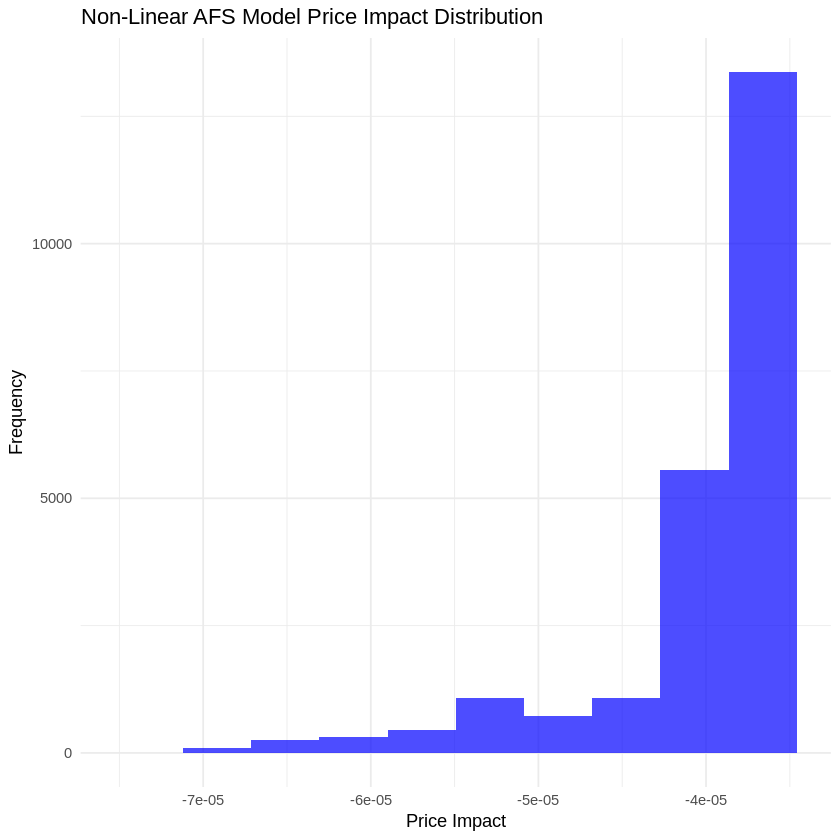

In [93]:
ggplot(data[data$afs_impact >= quantile(data$afs_impact, 0.25) - 1.5 * IQR(data$afs_impact) &
            data$afs_impact <= quantile(data$afs_impact, 0.75) + 1.5 * IQR(data$afs_impact), ]
  , aes(x = afs_impact)) +
  geom_histogram(bins = 10, fill = "blue", alpha = 0.7) +
  labs(title = "Non-Linear AFS Model Price Impact Distribution",
       x = "Price Impact",
       y = "Frequency") +
  theme_minimal()

**Problem 2**


In [ ]:
objective = function(Q, f, J, gamma, lambda, beta){
  return(mean(alpha*Q*f - beta*lambda*J*Q - (gamma*sigma^2 / 2)*Q^2))
}

alpha = 1.67e-4
sigma = 0.02
phi = 0.139

J_t = vector()
  for(i in 1:nrow(data)){
    J = 0
    for(j in 1:i){
      J = J + exp(-beta * data$time_index[i-j+1])*data$Signed.Volume[j]
    }
    J_t[i] = J
  }


#fixed lambda case

lambda = coef('ow_model')['lambda']
beta_list = seq(2,4,0.01)

SR1 = numeric(length(beta_list))
for(i in 1:length(beta_list)){
  beta = beta_list[i]
  gamma_hat = optim(1, function(gamma) objective(Q, f, J, gamma, lambda, beta), method = 'BFGS')$par
  Cf = (alpha * (1 + beta / phi)) / (gamma_hat * sigma^2) * sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2))
  CJ = sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2)) - 1

  E = mean(Cf*data$signal - CJ*J_t)
  risk <- (alpha^2 * sigma^2) / ((gamma_hat * sigma^2)^2) *
    ((beta / phi + 1)^2 * (beta / phi * sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2)) + 1)) /
    (sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2)) *
       (sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2)) + beta / phi)^3)

  SR1[i] = E/sqrt(risk)
}

#for fixed beta
lambda_list = seq(0.001,0.005,0.0001)
beta = coef('ow_model')['beta']

SR2 = numeric(length(lambda_list))
for(i in 1:length(lambda_list)){
  lambda = lambda_list[i]
  gamma_hat = optim(1, function(gamma) objective(Q, f, J, gamma, lambda, beta), method = 'BFGS')$par
  Cf = (alpha * (1 + beta / phi)) / (gamma_hat * sigma^2) * sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2))
  CJ = sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2)) - 1

  E = mean(Cf*data$signal - CJ*J_t)
  risk <- (alpha^2 * sigma^2) / ((gamma_hat * sigma^2)^2) *
    ((beta / phi + 1)^2 * (beta / phi * sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2)) + 1)) /
    (sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2)) *
       (sqrt(1 + (2 * lambda * beta) / (gamma_hat * sigma^2)) + beta / phi)^3)

  SR2[i] = E/sqrt(risk)
}

data2 = data.frame(
  param_value = beta_list
  sharpe = SR1
)

data3 = data.frame(
  param_value = lambda_list
  sharpe = SR2
)

ggplot(data2, aes(x = param_value, y = sharpe)) +
  geom_line(size = 1) +
  theme_minimal() +
  labs(
    title = "Fixed Lambda",
    x = "lambda",
    y = "Sharpe Ratio"
  )

ggplot(data3, aes(x = param_value, y = sharpe)) +
  geom_line(size = 1) +
  theme_minimal() +
  labs(
    title = "Fixed beta",
    x = "beta",
    y = "Sharpe Ratio"
  )

**Problem 3**

In [35]:
NetSimple = keras_model_sequential() %>%
  layer_dense(units = 128, activation = "relu", input_shape = 2) %>%  # Input: (f, J0)
  layer_dense(units = 32, activation = "relu", input_shape = 128) %>%
  layer_dense(units = 8, activation = "relu", input_shape = 32) %>%
  layer_dense(units = 1, activation = "linear", input_shape = 8)

NetPower = keras_model_sequential() %>%
  layer_dense(units = 128, activation = "relu", input_shape = 2) %>%  # Input: (f, J0)
  layer_dense(units = 32, activation = "relu", input_shape = 128) %>%
  layer_dense(units = 8, activation = "relu", input_shape = 32) %>%
  layer_dense(units = 1, activation = "linear", input_shape = 8)

NL = function(x, B, p, a, b){
  if(abs(x)<B){
    return (sign(x)*abs(x)^p)
  }
  else{
    return(a*x + sign(x)*b)
  }
}

NetLinear = keras_model_sequential() %>%
  layer_dense(units = 1, activation = "linear", input_shape = 2)

In [ ]:
NetSimple %>% compile(
  optimizer = optimizer_adam(learning_rate = 0.01),
  loss = function(y_true, y_pred){
    current_theta <- get_weights(NetSimple)
    gradient <- simulate_dynamics(NetSimple, f_n, current_theta)
    return(gradient)
  }
)

simulate_dynamics <- function(model, f_n, theta) {

  alpha = 1.67e-4
  beta = 2
  lambda = 0.0035
  dt = 0.01
  gamma = 1
  sigma = 0.02
  p = 1.8
  alpha_hat = alpha * (1-exp(-beta*dt))/(beta*dt)
  lambda_hat = lambda * (1-exp(-beta*(p+1)*p*dt))/(beta*(p+1)*dt)

  Q = numeric(N)
  J0 = numeric(N)
  J = numeric(N)

  # Initial values
  J0[1] = 0
  Q[1] = predict(model, matrix(c(f_n[1], J0[1]), ncol = 2))
  J[1] = Q[1]

  # Simulate dynamics for n = 2 to N
  for (n in 2:N) {
    Q[n] = as.numeric(predict(model, matrix(c(f_n[n - 1], J0[n - 1]), ncol = 2)))
    J0[n] = exp(-beta * dt) * J0[n - 1] - (1 - exp(-beta * dt)) * Q[n]
    J[n] = Q[n] + J0[n]
  }

  # Compute reward (objective function)
  reward = alpha_hat * Q * f_n - (gamma * sigma^2 / 2) * Q^2 - lambda_hat * abs(J)^(p + 1)
  total_reward = sum(reward)

  return(-total_reward)  # Return negative reward for minimization
}

f_n = na.omit(data1)$signal
N = length(f_n)

# Train the model
history1 <- NetSimple %>% fit(
  x = matrix(c(f_n[1:(N - 1)], rep(0, N - 1)), ncol = 2),  # Placeholder for initial inputs
  y = rep(0, N - 1),  # Placeholder target values
  epochs = 50,
  batch_size = 32
)

loss <- history1$metrics$loss
epochs <- seq_along(loss)

# Plot the training loss
plot(
  epochs, loss, type = "l",
  xlab = "Epoch", ylab = "Training Loss",
  main = "Training Loss vs. Epoch",
  col = "blue", lwd = 2
)

In [48]:
NetPower %>% compile(
  optimizer = optimizer_adam(learning_rate = 0.01),
  loss = function(y_true, y_pred){
    current_theta <- get_weights(NetPower)
    gradient <- simulate_dynamics(NetPower, f_n, current_theta)
    return(gradient)
  }
)

simulate_dynamics <- function(model, f_n, theta) {

  alpha = 1.67e-4
  beta = 2
  lambda = 0.0035
  dt = 0.01
  gamma = 1
  sigma = 0.02
  p = 1.8
  alpha_hat = alpha * (1-exp(-beta*dt))/(beta*dt)
  lambda_hat = lambda * (1-exp(-beta*(p+1)*p*dt))/(beta*(p+1)*dt)
  B = 10000
  a = (1/p)*(B^((1/p)-1))
  b = (1-(1/p))*B^(1/p)

  Q = numeric(N)
  J0 = numeric(N)
  J = numeric(N)

  # Initial values
  J0[1] = 0
  Q[1] = predict(model, matrix(c(f_n[1], J0[1]), ncol = 2))
  J[1] = Q[1]

  # Simulate dynamics for n = 2 to N
  for (n in 2:N) {
    Q[n] = NL(as.numeric(predict(model, matrix(c(f_n[n - 1], J0[n - 1]), ncol = 2))), B, p, a, b)
    J0[n] = exp(-beta * dt) * J0[n - 1] - (1 - exp(-beta * dt)) * Q[n]
    J[n] = Q[n] + J0[n]
  }

  # Compute reward (objective function)
  reward = alpha_hat * Q * f_n - (gamma * sigma^2 / 2) * Q^2 - lambda_hat * abs(J)^(p + 1)
  total_reward = sum(reward)

  return(-total_reward)  # Return negative reward for minimization
}

f_n = na.omit(data1)$signal
N = length(f_n)

# Train the model
history2 <- NetPower %>% fit(
  x = matrix(c(f_n[1:(N - 1)], rep(0, N - 1)), ncol = 2),  # Placeholder for initial inputs
  y = rep(0, N - 1),  # Placeholder target values
  epochs = 50,
  batch_size = 32
)

loss <- history2$metrics$loss
epochs <- seq_along(loss)

# Plot the training loss
plot(
  epochs, loss, type = "l",
  xlab = "Epoch", ylab = "Training Loss",
  main = "Training Loss vs. Epoch",
  col = "blue", lwd = 2
)

-1.276532e-04,0
-1.509814e-04,0
-1.119657e-04,0
-8.906570e-05,0
-8.652302e-05,0
-8.355611e-05,0
-1.849310e-04,0
-1.764494e-04,0
-3.266075e-04,0
-2.672288e-04,0
-2.820767e-04,0


In [ ]:
NetLinear %>% compile(
  optimizer = optimizer_adam(learning_rate = 0.01),
  loss = function(y_true, y_pred){
    current_theta <- get_weights(NetLinear)
    gradient <- simulate_dynamics(NetLinear, f_n, current_theta)
    return(gradient)
  }
)

simulate_dynamics <- function(model, f_n, theta) {

  alpha = 1.67e-4
  beta = 2
  lambda = 0.0035
  dt = 0.01
  gamma = 1
  sigma = 0.02
  p = 1.8
  alpha_hat = alpha * (1-exp(-beta*dt))/(beta*dt)
  lambda_hat = lambda * (1-exp(-beta*(p+1)*p*dt))/(beta*(p+1)*dt)

  Q = numeric(N)
  J0 = numeric(N)
  J = numeric(N)

  # Initial values
  J0[1] = 0
  Q[1] = predict(model, matrix(c(f_n[1], J0[1]), ncol = 2))
  J[1] = Q[1]

  # Simulate dynamics for n = 2 to N
  for (n in 2:N) {
    Q[n] = as.numeric(predict(model, matrix(c(f_n[n - 1], J0[n - 1]), ncol = 2)))
    J0[n] = exp(-beta * dt) * J0[n - 1] - (1 - exp(-beta * dt)) * Q[n]
    J[n] = Q[n] + J0[n]
  }

  # Compute reward (objective function)
  reward = alpha_hat * Q * f_n - (gamma * sigma^2 / 2) * Q^2 - lambda_hat * abs(J)^(p + 1)
  total_reward = sum(reward)

  return(-total_reward)  # Return negative reward for minimization
}

f_n = na.omit(data1)$signal
N = length(f_n)

# Train the model
history3 <- NetLinear %>% fit(
  x = matrix(c(f_n[1:(N - 1)], rep(0, N - 1)), ncol = 2),  # Placeholder for initial inputs
  y = rep(0, N - 1),  # Placeholder target values
  epochs = 50,
  batch_size = 32
)

loss <- history3$metrics$loss
epochs <- seq_along(loss)

# Plot the training loss
plot(
  epochs, loss, type = "l",
  xlab = "Epoch", ylab = "Training Loss",
  main = "Training Loss vs. Epoch",
  col = "blue", lwd = 2
)